# Testing notebook for nifty fit on atmosphere TODs directly (no image)

# Try to add a nifty model for sampling the input map

numpy version: 2.1.1


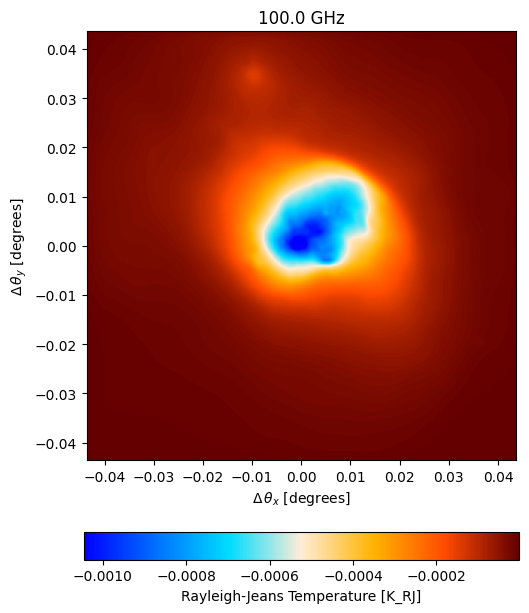

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('../python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

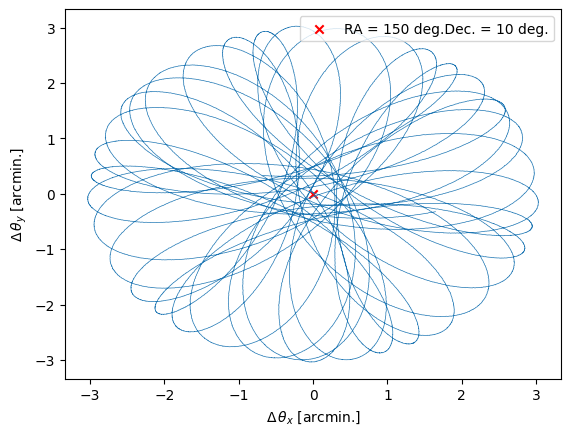

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                    # duration=60,
                    #   duration=300, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

2024-10-28 10:31:01.570 INFO: Initialized base in 1502 ms.
Building atmosphere: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]
2024-10-28 10:31:07.428 INFO: Initialized atmosphere in 5831 ms.
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


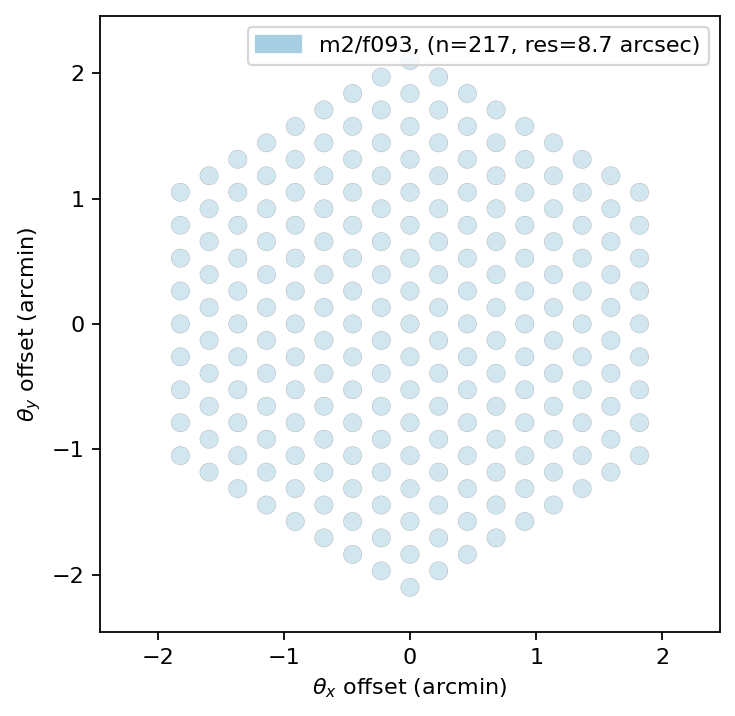

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.instrument
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[-1.96478520e-04, -1.92513015e-04, -1.89575182e-04, ...,
         4.73645003e-04,  4.77080691e-04,  4.78493835e-04],
       [-2.45597613e-04, -2.41632288e-04, -2.38694552e-04, ...,
         4.28298375e-04,  4.31733857e-04,  4.33147031e-04],
       [-1.21288330e-04, -1.17322866e-04, -1.14385055e-04, ...,
         5.49523001e-04,  5.52958661e-04,  5.54371809e-04],
       ...,
       [ 1.21284057e-04,  1.25251042e-04,  1.28189668e-04, ...,
         7.60539980e-04,  7.63977344e-04,  7.65390248e-04],
       [-4.05047275e-04, -4.01080002e-04, -3.98141223e-04, ...,
         2.29393989e-04,  2.32831553e-04,  2.34244428e-04],
       [-7.45857856e-04, -7.41892465e-04, -7.38954693e-04, ...,
        -7.23162545e-05, -6.88808061e-05, -6.74676278e-05]])

Running mapper (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.47s/it]


mapdata_truth shape: (1, 1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


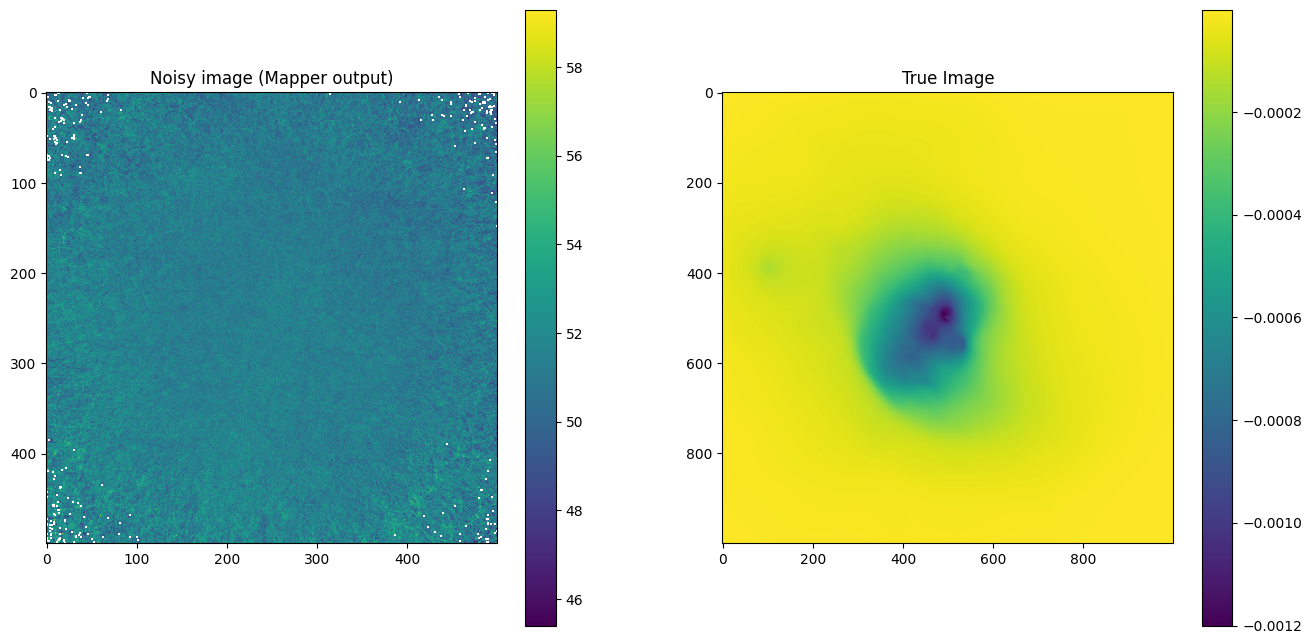

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0, 0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
from jax import random
import jax.numpy as jnp

import nifty8.re as jft
import matplotlib.pyplot as plt

import numpy as np

from functools import reduce
from operator import or_

seed = 42
key = random.PRNGKey(seed)

2024-10-28 10:31:21.346 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-28 10:31:21.347 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Prepare noised input TODs:

Noise stddev: 0.00025131798439141466


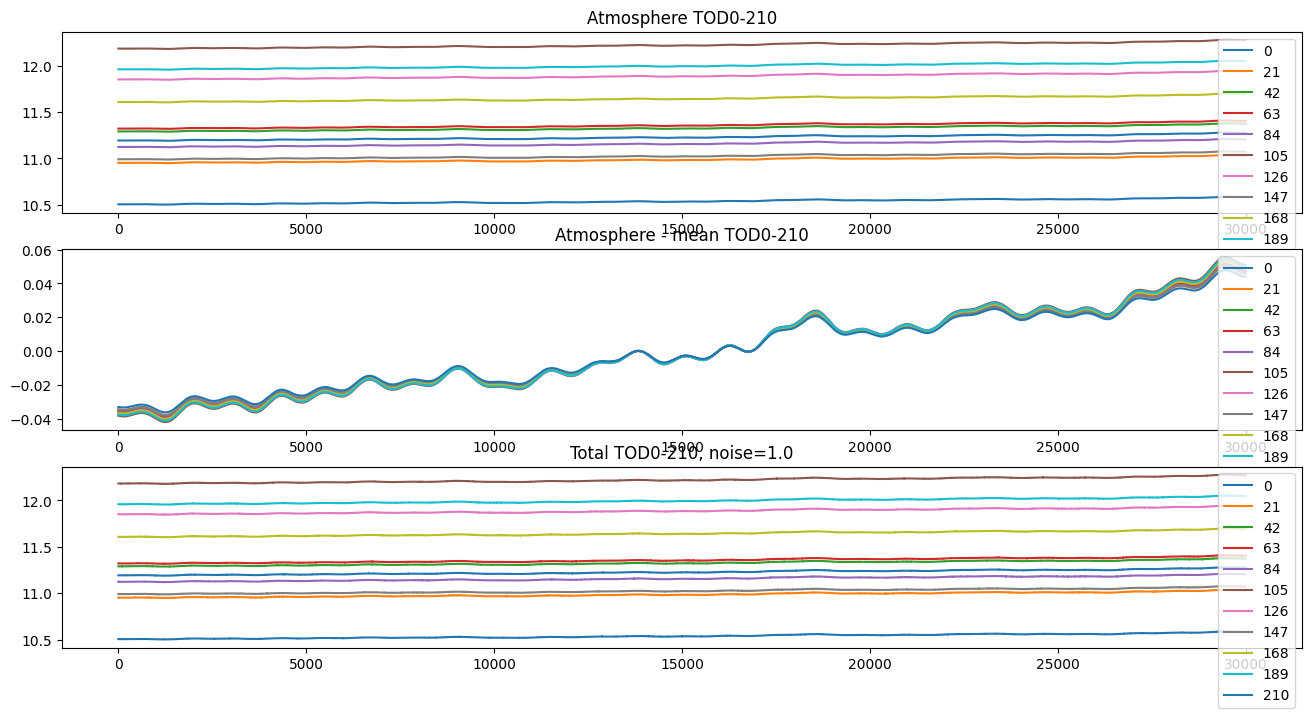

In [7]:
# Pick noise level for rest of run:
# noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
noiselevel = 1.0

jax_tods_atmos = tod_truthmap.get_field('atmosphere')

# Add n TODs for atmos:
# n = 1
# n = 2
# n = 10
# n = 100
n = jax_tods_atmos.shape[0]

noised_jax_tod = np.float64(jax_tods_atmos)[:n] + np.float64(tod_truthmap.get_field('noise')*noiselevel)[:n]
denoised_jax_tod = noised_jax_tod - np.float64(tod_truthmap.get_field('noise')*noiselevel)[:n]

print("Noise stddev:", np.std(tod_truthmap.get_field('noise').compute()))

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10 if n//10 != 0 else 1):
    im0 = axes[0].plot(jax_tods_atmos[i], label=i)
    im1 = axes[1].plot(jax_tods_atmos[i] - jax_tods_atmos[i].mean(), label=i)
    im2 = axes[2].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'Atmosphere TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'Atmosphere - mean TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'Total TOD0-{i}, noise={noiselevel}')
axes[2].legend()

plt.show()

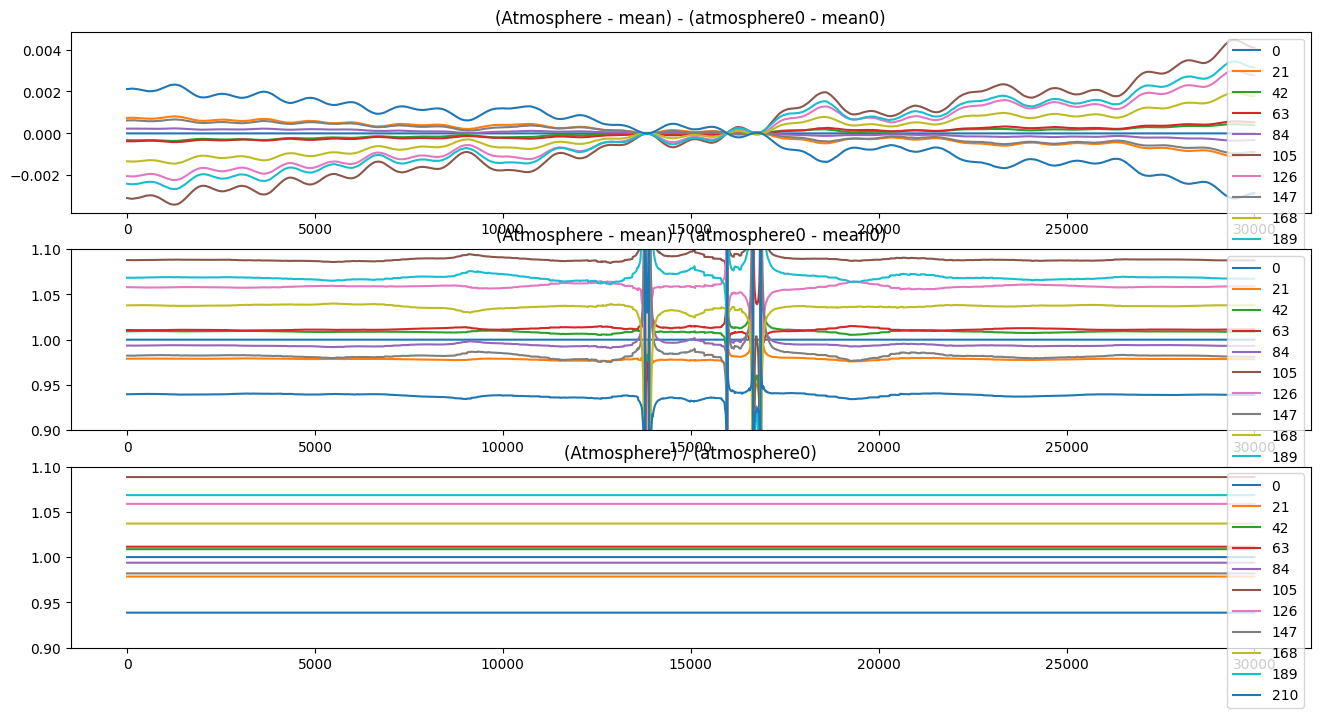

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10 if n//10 != 0 else 1):
    axes[0].plot(jax_tods_atmos[i] - jax_tods_atmos[i].mean() - (jax_tods_atmos[0] - jax_tods_atmos[0].mean()), label=i)
    axes[1].plot( (jax_tods_atmos[i] - jax_tods_atmos[i].mean()) / (jax_tods_atmos[0] - jax_tods_atmos[0].mean()), label=i)
    axes[2].plot( (jax_tods_atmos[i]) / (jax_tods_atmos[0]), label=i)
    
axes[0].title.set_text(f'(Atmosphere - mean) - (atmosphere0 - mean0)')
axes[0].legend()
axes[1].title.set_text(f'(Atmosphere - mean) / (atmosphere0 - mean0)')
axes[1].legend()
axes[1].set_ylim([0.9, 1.1])
axes[2].title.set_text(f'(Atmosphere) / (atmosphere0)')
axes[2].legend()
axes[2].set_ylim([0.9, 1.1])

plt.show()

In [36]:
print("real slopes:")
slopes_truth = (jax_tods_atmos - jax_tods_atmos.mean(axis=1)[:, None]) / (jax_tods_atmos[0] - jax_tods_atmos[0].mean())
slopes_truth_2 = (jax_tods_atmos) / (jax_tods_atmos[0])
# slice to regularise:
# slopes_truth = slopes_truth[:, :5000].mean(axis=1)
# slopes_truth_2 = slopes_truth_2[:, :5000].mean(axis=1)
slopes_truth = slopes_truth.mean(axis=1)
slopes_truth_2 = slopes_truth_2.mean(axis=1)
print(slopes_truth.shape)

(slopes_truth - slopes_truth_2).compute()
# (slopes_truth).compute()

real slopes:
(217,)


array([ 1.26536337e-10, -2.13065436e-04, -1.84672429e-05,  1.86478160e-05,
        1.99564671e-04, -2.33304629e-04,  2.55335315e-04, -2.51487688e-04,
       -2.06034187e-04, -3.13106341e-05, -4.38163059e-04, -4.17349804e-04,
        4.41551955e-04,  4.82713503e-04,  3.36574663e-05,  2.38209248e-04,
        2.08730437e-04,  4.88837360e-04, -5.06029859e-04, -6.39248179e-04,
       -3.77240609e-04, -3.99201801e-05,  2.60458178e-04,  4.52581643e-04,
        7.13376371e-04, -6.59542361e-04, -2.82629071e-04,  6.51328646e-04,
        7.06667581e-04, -6.63605334e-04, -4.54150684e-04, -7.48724040e-04,
        4.03265376e-04, -1.68909151e-04,  7.06300404e-04,  5.00879107e-05,
        1.74664521e-04,  4.74318864e-04, -8.87911155e-04, -6.99134436e-04,
        7.85539851e-04,  4.33966143e-04,  1.79493123e-04, -7.93715370e-04,
        6.75068956e-04,  2.85749510e-04,  9.12725383e-04,  7.33194671e-05,
       -4.62024695e-05, -4.29049581e-04, -2.81992227e-04,  8.55223870e-04,
        7.59198507e-04,  

# Get offsets:

deviation_mean: 2.4253192047278088e-16
deviation std: 0.5652795663809732
deviation_truth mean: -5.495125774450431e-15
deviation_truth std: 0.5652795481041231


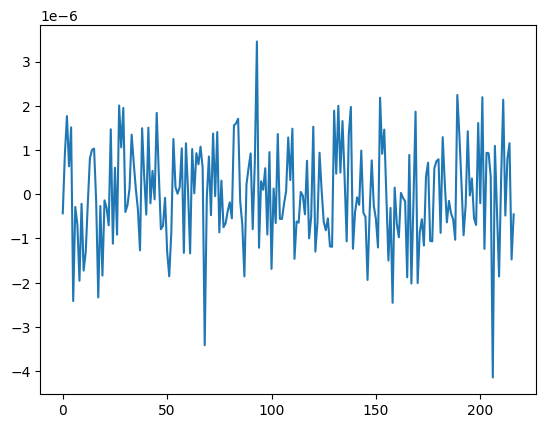

In [37]:
deviation_truth = (jax_tods_atmos - jax_tods_atmos.mean()).compute()
deviation = noised_jax_tod - noised_jax_tod.mean()

print("deviation_mean:", deviation.mean())
print("deviation std:", deviation.std())
print("deviation_truth mean:", deviation_truth.mean())
print("deviation_truth std:", deviation_truth.std())

offset_tod = jnp.float64(deviation.mean(axis=1)[:n])
offset_tod_truth = jnp.float64(deviation_truth.mean(axis=1)[:n])

plt.plot(offset_tod - offset_tod_truth)

# for testing:
# offset_tod = offset_tod_truth

np.float64(1.6294151172547074e-13)

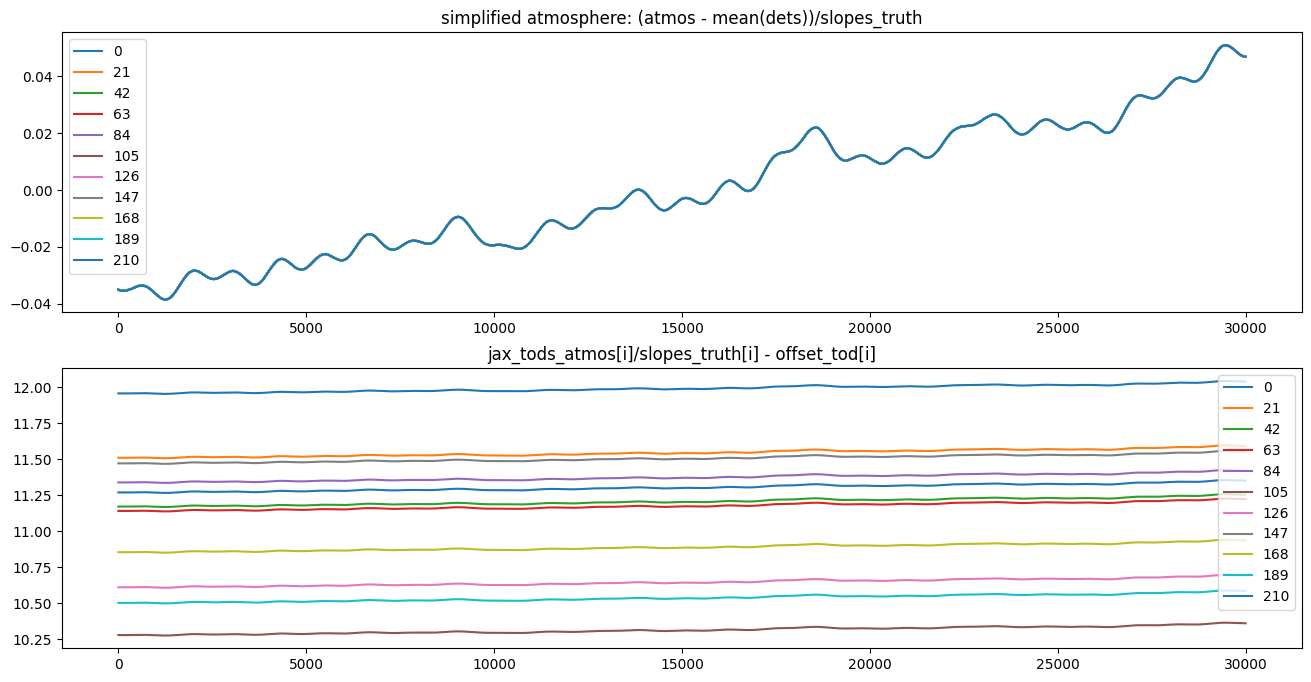

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# slopes_truth = (jax_tods_atmos - jax_tods_atmos.mean(axis=1)[:, None]) / (jax_tods_atmos[0] - jax_tods_atmos[0].mean())
# slopes_truth = (jax_tods_atmos - jax_tods_atmos.mean()) / (jax_tods_atmos[0] - jax_tods_atmos.mean())


offset_tod_truth = np.float64(jax_tods_atmos.mean(axis=1))
# slopes_truth = np.float64(slopes_truth)
slopes_truth = np.float64(slopes_truth_2)
atmos_tod_simplified = (jax_tods_atmos - offset_tod_truth[:, None])/slopes_truth[:, None]

for i in range(0, n, n//10 if n//10 != 0 else 1):
    # axes[0].plot( (jax_tods_atmos[i] - jax_tods_atmos[i].mean())/slopes_truth[i], label=i)
    axes[0].plot( atmos_tod_simplified[i], label=i)

    axes[1].plot( (jax_tods_atmos[i]/slopes_truth[i] - offset_tod[i]), label=i)
    # axes[1].plot( (jax_tods_atmos[i] - offset_tod[i]), label=i)

axes[0].title.set_text(f'simplified atmosphere: (atmos - mean(dets))/slopes_truth')
axes[0].legend()
axes[1].title.set_text(f'jax_tods_atmos[i]/slopes_truth[i] - offset_tod[i]')
axes[1].legend()

atmos_tod_simplified.mean().compute()

# Next, initialise nifty prior model

Start with the atmosphere TOD model. For this, we need to re-write the CorrelatedFieldMaker:

In [40]:
import jax

import jax.numpy as jnp
import numpy as np
import nifty8.re as jft
import matplotlib.pyplot as plt

from functools import partial
from nifty8.re.correlated_field import Model, RegularCartesianGrid, hartley, HEALPixGrid, get_sht, ShapeWithDtype, random_like

key = jax.random.PRNGKey(42)

In [41]:
class CFM(jft.CorrelatedFieldMaker):
    def __init__(self, prefix):
        super().__init__(prefix)

    def finalize(self, n_fields: int = 0) -> Model:
        """Finishes off the model construction process and returns the
        constructed operator.
        """
        harmonic_transforms = []
        excitation_shape = ()
        for sgrid in self._target_grids:
            sub_shp = None
            sub_shp = sgrid.harmonic_grid.shape
            excitation_shape += sub_shp
            n = len(excitation_shape)
            harmonic_dvol = 1.0 / sgrid.total_volume
            if isinstance(sgrid, RegularCartesianGrid):
                axes = tuple(range(n - len(sub_shp), n))
                # TODO: Generalize to complex
                trafo = partial(hartley, axes=axes)
            elif isinstance(sgrid, HEALPixGrid):
                axis = len(excitation_shape) - 1
                trafo = get_sht(
                    nside=sgrid.nside,
                    axis=axis,
                    lmax=sgrid.harmonic_grid.lmax,
                    mmax=sgrid.harmonic_grid.mmax,
                    nthreads=1,
                )
            harmonic_transforms.append((harmonic_dvol, trafo))

        # Register the parameters for the excitations in harmonic space
        # TODO: actually account for the dtype here
        pfx = self._prefix + "xi"
        if n_fields > 0:
            xi_shape = (n_fields,) + excitation_shape
        else:
            xi_shape = excitation_shape
        self._parameter_tree[pfx] = ShapeWithDtype(xi_shape)

        def outer_harmonic_transform(p):
            harmonic_dvol, ht = harmonic_transforms[0]
            outer = harmonic_dvol * ht(p)
            for harmonic_dvol, ht in harmonic_transforms[1:]:
                outer = harmonic_dvol * ht(outer)
            return outer

        def _mk_expanded_amp(amp, sub_dom):  # Avoid late binding
            def expanded_amp(p):
                return amp(p)[sub_dom.harmonic_grid.power_distributor]

            return expanded_amp

        expanded_amplitudes = []
        namps = self.get_normalized_amplitudes()
        for amp, sgrid in zip(namps, self._target_grids):
            expanded_amplitudes.append(_mk_expanded_amp(amp, sgrid))

        def outer_amplitude(p):
            outer = expanded_amplitudes[0](p)
            for amp in expanded_amplitudes[1:]:
                # NOTE, the order is important here and must match with the
                # excitations
                # TODO, use functions instead and utilize numpy's casting
                outer = jnp.tensordot(outer, amp(p), axes=0)
            return outer

        def correlated_field(p):
            ea = outer_amplitude(p)
            cf_h = self.azm(p) * ea * p[self._prefix + "xi"]
            return self._offset_mean + outer_harmonic_transform(cf_h)
        
        p_dct = {k: 0 if 'xi' in k else None for k in self._parameter_tree}
        cfm_vmap = jax.vmap(correlated_field, in_axes=(p_dct,))

        init = {
            k: partial(random_like, primals=v) for k, v in self._parameter_tree.items()
        }
        cf = Model(cfm_vmap, domain=self._parameter_tree.copy(), init=init)
        cf.normalized_amplitudes = namps
        cf.target_grids = tuple(self._target_grids)
        return cf

In [42]:
# padding_atmos = 2000
# padding_atmos = 5000
padding_atmos = 10000
dims_atmos = ( (jax_tods_atmos.shape[1] + padding_atmos), )
# dims_atmos = ( (jax_tods_atmos.shape[1] - 200 + padding_atmos), )

# correlated field zero mode GP offset and stddev
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0002, 0.0001))
# cf_zm_tod = dict(offset_mean=0.0, offset_std=(0.0002, 0.0001))
# cf_zm_tod = dict(offset_mean=0.0, offset_std=(1e-6, 0.5e-6))
cf_zm_tod = dict(offset_mean=0.0, offset_std=(1e-5, 0.99e-5))

# correlated field fluctuations (mostly don't need tuning)
# fluctuations: y-offset in power spectrum in fourier space (zero mode)
# loglogavgslope: power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
# flexibility=(1.5e0, 5e-1), # deviation from simple power-law
# asperity=(5e-1, 5e-2), # small scale features in power-law
cf_fl_tod = dict(
    # fluctuations=(0.005, 0.003), 
    # fluctuations=(0.001, 0.0005),
    fluctuations=(0.002, 0.001),
    # loglogavgslope=(-3, 0.5), 
    # loglogavgslope=(-2, 0.5), 
    loglogavgslope=(-2.5, 0.5), 
    flexibility=None,
    asperity=None,
)

# put together in correlated field model
# Custom CFM:
cfm_tod = CFM("combcf ")
cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
cfm_tod.add_fluctuations(
    dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
)
gp_tod = cfm_tod.finalize(n)
gp_tod

# Old: default CFM:
# cfm_tod = jft.CorrelatedFieldMaker("")
# cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
# cfm_tod.add_fluctuations(
#     dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
# )
# # init params for each TOD:
# gps_tods = []
# for i in range(n):
#     cfmi = jft.CorrelatedFieldMaker(f'tod{i} ')
#     # cfmi.set_amplitude_total_offset(**cf_zm_tod)
#     cfmi._azm = cfm_tod._azm
#     cfmi._offset_mean = cfm_tod._offset_mean
#     cfmi._parameter_tree['zeromode'] = jft.ShapeWithDtype(())

#     cfmi._fluctuations.append(cfm_tod._fluctuations[0])
#     cfmi._target_grids.append(cfm_tod._target_grids[0])
#     cfmi._parameter_tree.update(cfm_tod._fluctuations[0].domain)
#     gps_tods.append(cfmi.finalize())
# gps_tods

Model(
	<function CFM.finalize.<locals>.correlated_field at 0x1509d5e78c20>,
	domain={'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'combcf tod fluctuations': functools.partial(<function random_like at 0x1509bc4ce480>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf tod loglogavgslope': functools.partial(<function random_like at 0x1509bc4ce480>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf xi': functools.partial(<function random_like at 0x1509bc4ce480>, primals=ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>)),
		 'combcf zeromode': functools.partial(<function random_like at 0x1

# Define offset NormalPrior:

In [43]:
# offset_dict = dict(mean = 0.0, std = 0.6, shape=(n,))
# offset_tod = jft.NormalPrior(**offset_dict, name='offset')

# offset_tod

# OLD Signal model:

In [44]:
# class Signal_TOD(jft.Model):
#     def __init__(self, gps_tods):
#         self.gps_tods = gps_tods
#         self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         super().__init__(init=reduce(or_, [gp.init for gp in gps_tods]), domain=reduce(or_, [gp.domain for gp in gps_tods]))
    
#     def __call__(self, x):
#         res_tods = jnp.zeros(self.tgt)
#         for i, gp in enumerate(self.gps_tods):
#             res_tods = res_tods.at[i].set(gp(x))
        
#         return res_tods[:, padding_atmos//2:-padding_atmos//2]

# signal_response_tod = Signal_TOD(gps_tods)

# CFM - TOD

In [45]:
class Signal_TOD(jft.Model):
    def __init__(self, gp_tod, offset_tod):
        self.gp_tod = gp_tod
        self.offset_tod = offset_tod
        # super().__init__(init = self.gp_tod.init | self.offset_tod.init, domain = self.gp_tod.domain | self.offset_tod.domain )
        super().__init__(init = self.gp_tod.init, domain = self.gp_tod.domain )
    
    def __call__(self, x):
        x_tod = {k: x[k] for k in x if 'comb' in k}
        res_tods = self.gp_tod(x_tod)
        # res_tods = self.gp_tod(x)

        # For offset NormalPrior:
        # res_tods = res_tods[:, padding_atmos//2:-padding_atmos//2] + self.offset_tod(x)[:, jax.numpy.newaxis]
        # For fixed offsets:
        # res_tods = res_tods[:, padding_atmos//2:-padding_atmos//2] + self.offset_tod[:, jax.numpy.newaxis]
        # For simple inputs:
        # res_tods = res_tods[:, padding_atmos//2:-padding_atmos//2]
        # Reverse de-trending:
        res_tods = res_tods[:, padding_atmos//2:-padding_atmos//2] * slopes_truth[:, None] + offset_tod_truth[:, None]

        return res_tods

signal_response_tod = Signal_TOD(gp_tod, offset_tod)

In [46]:
# Define noise covariance
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Test with simple atmos TODs:
# noised_jax_tod = np.float64(atmos_tod_simplified)[:n] + np.float64(tod_truthmap.get_field('noise')*noiselevel)[:n]
# denoised_jax_tod = np.float64(atmos_tod_simplified)[:n]

# Combine in likelihood
truth = noised_jax_tod[:n]

print(truth.shape)
lh_tod = jft.Gaussian( truth, noise_cov_inv_tod).amend(signal_response_tod)

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


(217, 30000)


In [47]:
signal_response_tod

Signal_TOD(
	<bound method Signal_TOD.__call__>,
	domain={'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'combcf tod fluctuations': functools.partial(<function random_like at 0x1509bc4ce480>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf tod loglogavgslope': functools.partial(<function random_like at 0x1509bc4ce480>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf xi': functools.partial(<function random_like at 0x1509bc4ce480>, primals=ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>)),
		 'combcf zeromode': functools.partial(<function random_like at 0x1509bc4ce480>, primals=ShapeW

# Draw Prior sample

(217, 30000)


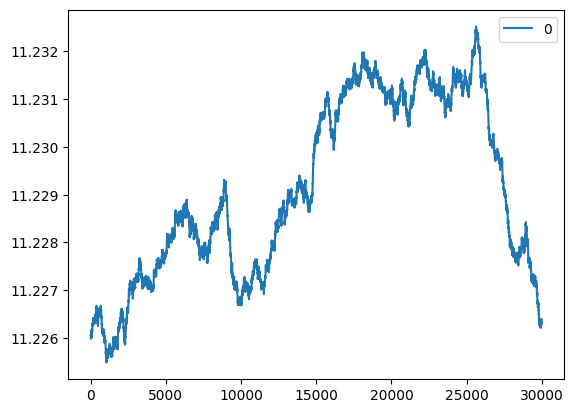

In [48]:
key, sub = jax.random.split(key)
xi = jft.random_like(sub, signal_response_tod.domain)
res = signal_response_tod(xi)
print(res.shape)

# for i in range(res.shape[0]):
# for i in range(0, n, n//10):
for i in [0]:
    plt.plot(np.arange(0, res.shape[1]), res[i], label=i)
plt.legend()
plt.show()

# MAP fit

In [49]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:9.334783e+03 ➽:8.680003e+02
M: Iteration 1 ⛰:+1.698599e+10 Δ⛰:1.259259e+10
M: →:0.5 ↺:False #∇²:12 |↘|:9.340553e+03 ➽:8.680003e+02
M: Iteration 2 ⛰:+3.077613e+09 Δ⛰:1.390838e+10
M: →:1.0 ↺:False #∇²:18 |↘|:2.862222e+03 ➽:8.680003e+02
M: Iteration 3 ⛰:+5.282474e+08 Δ⛰:2.549365e+09
M: →:1.0 ↺:False #∇²:24 |↘|:4.109832e+03 ➽:8.680003e+02
M: Iteration 4 ⛰:+3.494464e+08 Δ⛰:1.788010e+08
M: →:1.0 ↺:False #∇²:30 |↘|:2.659006e+03 ➽:8.680003e+02
M: Iteration 5 ⛰:+2.761343e+08 Δ⛰:7.331210e+07
M: →:1.0 ↺:False #∇²:36 |↘|:2.891845e+03 ➽:8.680003e+02
M: Iteration 6 ⛰:+2.323816e+08 Δ⛰:4.375274e+07
M: →:1.0 ↺:False #∇²:42 |↘|:1.583440e+03 ➽:8.680003e+02
M: Iteration 7 ⛰:+2.018523e+08 Δ⛰:3.052926e+07
M: →:1.0 ↺:False #∇²:48 |↘|:2.700691e+03 ➽:8.680003e+02
M: Iteration 8 ⛰:+1.776003e+08 Δ⛰:2.425202e+07
M: →:1.0 ↺:False #∇²:54 |↘|:1.113650e+03 ➽:8.680003e+02
M: Iteration 9 ⛰:+1.575218e+08 Δ⛰:2.007848e+07
M: →:1.0 ↺:False #∇²:60 |↘|:2.710260e+03 ➽:8.6

In [50]:
samples.pos

Vector(
	{'combcf tod fluctuations': Array(1.39421511, dtype=float64),
	 'combcf tod loglogavgslope': Array(1.58397151, dtype=float64),
	 'combcf xi': Array([[ 0.74304485,  9.1206249 ,  4.97108353, ..., -5.43661442,
	        -5.89092546, -8.49956453],
	       [ 0.7250237 ,  9.09822682,  4.99164687, ..., -4.91821426,
	        -5.57760234, -8.4520946 ],
	       [ 1.71483238,  9.21425987,  5.22446737, ..., -5.11593788,
	        -5.72369024, -8.48317051],
	       ...,
	       [ 0.8063196 ,  9.06235098,  4.77291265, ..., -4.75389969,
	        -5.5420001 , -8.42269296],
	       [ 0.10218717,  9.15470632,  5.10670117, ..., -5.40621264,
	        -5.8790299 , -8.54886064],
	       [ 2.05135165,  9.12214677,  5.01531087, ..., -4.59519782,
	        -5.53611718, -8.35425586]], dtype=float64),
	 'combcf zeromode': Array(2.80002017, dtype=float64)}
)

In [51]:
def printfitresults():
    print("Fit Results (res, init, std)")

    print("\nTODs:")
    # NEW model:
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['combcf tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['combcf tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['combcf zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")
    # OLD model:
    # print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    # print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    # print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")

    # offset per detector:
    # offset_results = jft.NormalPrior(**offset_dict)(samples.pos['offset'])
    # print(f"\toffset: ({offset_results.mean()}, {offset_results.std()}), {offset_dict['mean']}, {offset_dict['std']}")
    # # residual offset:
    # offset_residuals = offset_results - jnp.float64(deviation.mean(axis=1)[:n].compute())
    # print(f"\toffset residuals: ({offset_residuals.mean()}, {offset_residuals.std()})")

    # If custom zeromode per TOD:
    # for i in range(n):
    #     test = samples.pos[f"tod{i} zeromode"]
    #     print(f"tod{i} zeromode: {jft.LogNormalPrior(cf_zm_tod['offset_mean'], cf_zm_tod['offset_std'][0])(test)}, {cf_zm_tod['offset_mean']}, {cf_zm_tod['offset_std'][0]}")
    
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.003456220846045773, 0.002, 0.001
	loglogvarslope: -1.7080142468994963, -2.5, 0.5
	zeromode std (LogNormal): 7.19020289928478e-05, 1e-05, 9.9e-06


(217, 30000)


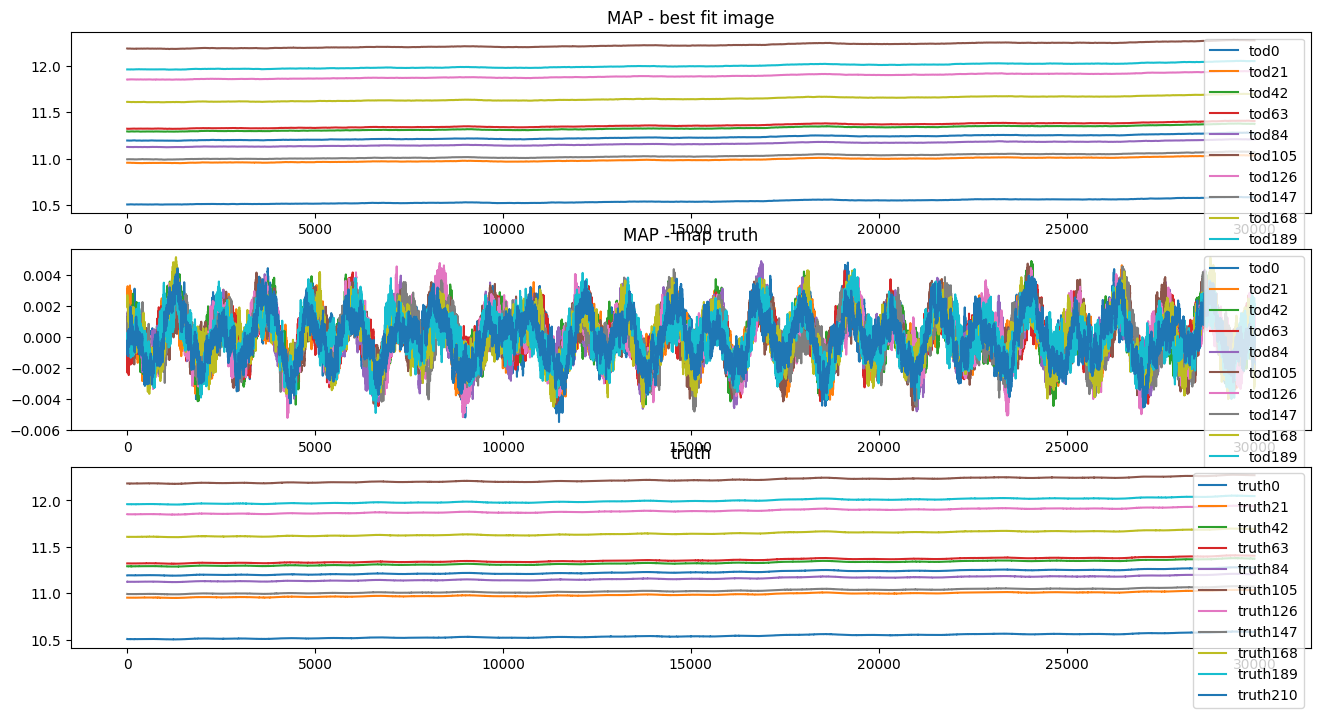

In [52]:
res = signal_response_tod(samples.pos)
print(res.shape)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10 if n//10 != 0 else 1):
    im0 = axes[0].plot(np.arange(0, res.shape[1]), res[i], label=f"tod{i}")
    im1 = axes[1].plot(np.arange(0, res.shape[1]), res[i] - truth[i], label=f"tod{i}")
    im2 = axes[2].plot(truth[i], label=f"truth{i}")

axes[0].title.set_text('MAP - best fit image')
axes[0].legend()
axes[1].title.set_text('MAP - map truth')
axes[1].legend()
axes[2].title.set_text('truth')
axes[2].legend()

plt.show()

In [53]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+8.7380e+07 Δ⛰:inf ➽:8.6800e+01
SL: Iteration 1 ⛰:+6.2135e+07 Δ⛰:2.5245e+07 ➽:8.6800e+01
SL: Iteration 2 ⛰:+9.6497e+06 Δ⛰:5.2486e+07 ➽:8.6800e+01
SL: Iteration 3 ⛰:+8.2862e+06 Δ⛰:1.3635e+06 ➽:8.6800e+01
SL: Iteration 4 ⛰:+4.3042e+06 Δ⛰:3.9820e+06 ➽:8.6800e+01
SL: Iteration 5 ⛰:+8.2516e+05 Δ⛰:3.4791e+06 ➽:8.6800e+01
SL: Iteration 6 ⛰:-8.8976e+05 Δ⛰:1.7149e+06 ➽:8.6800e+01
SL: Iteration 7 ⛰:-1.2394e+06 Δ⛰:3.4964e+05 ➽:8.6800e+01
SL: Iteration 8 ⛰:-1.2520e+06 Δ⛰:1.2609e+04 ➽:8.6800e+01
SL: Iteration 9 ⛰:-1.8634e+06 Δ⛰:6.1142e+05 ➽:8.6800e+01
SL: Iteration 10 ⛰:-2.4738e+06 Δ⛰:6.1033e+05 ➽:8.6800e+01
SL: Iteration 11 ⛰:-2.6388e+06 Δ⛰:1.6499e+05 ➽:8.6800e+01
SL: Iteration 12 ⛰:-2.8325e+06 Δ⛰:1.9377e+05 ➽:8.6800e+01
SL: Iteration 13 ⛰:-3.0388e+06 Δ⛰:2.0631e+05 ➽:8.6800e+01
SL: Iteration 14 ⛰:-3.1081e+06 Δ⛰:6.9227e+04 ➽:8.6800e+01
SL: Iteration 15 ⛰:-3.1209e+06 Δ⛰:1.2814e+04 ➽:8.6800e+01
SL: Iteration 16 ⛰:-3.2595e+06 Δ⛰:1.3858e+05 ➽:8.6800e+01
SL: 

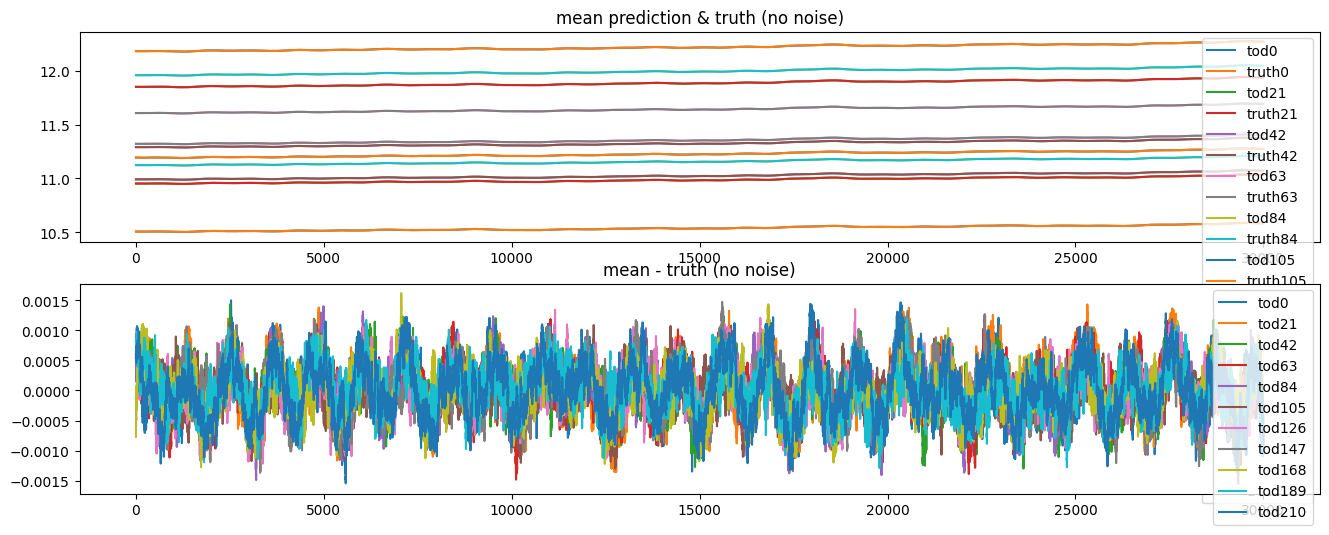

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+3.4225e+09 Δ⛰:inf ➽:8.6800e+01
SL: Iteration 1 ⛰:+2.2900e+08 Δ⛰:3.1935e+09 ➽:8.6800e+01
SL: Iteration 2 ⛰:+1.1283e+08 Δ⛰:1.1617e+08 ➽:8.6800e+01
SL: Iteration 3 ⛰:+3.9174e+07 Δ⛰:7.3660e+07 ➽:8.6800e+01
SL: Iteration 4 ⛰:+2.6257e+07 Δ⛰:1.2917e+07 ➽:8.6800e+01
SL: Iteration 5 ⛰:+2.5923e+07 Δ⛰:3.3382e+05 ➽:8.6800e+01
SL: Iteration 6 ⛰:+1.7929e+07 Δ⛰:7.9938e+06 ➽:8.6800e+01
SL: Iteration 7 ⛰:+1.4801e+07 Δ⛰:3.1280e+06 ➽:8.6800e+01
SL: Iteration 8 ⛰:+1.4795e+07 Δ⛰:6.1328e+03 ➽:8.6800e+01
SL: Iteration 9 ⛰:+1.1445e+07 Δ⛰:3.3507e+06 ➽:8.6800e+01
SL: Iteration 10 ⛰:+1.1444e+07 Δ⛰:3.2128e+02 ➽:8.6800e+01
SL: Iteration 11 ⛰:+9.2952e+06 Δ⛰:2.1491e+06 ➽:8.6800e+01
SL: Iteration 12 ⛰:+8.1796e+06 Δ⛰:1.1156e+06 ➽:8.6800e+01
SL: Iteration 13 ⛰:+6.4893e+06 Δ⛰:1.6903e+06 ➽:8.6800e+01
SL: Iteration 14 ⛰:+6.4892e+06 Δ⛰:9.7343e+01 ➽:8.6800e+01
SL: Iteration 15 ⛰:+6.4869e+06 Δ⛰:2.3775e+03 ➽:8.6800e+01
SL: Iteration 16 ⛰:+5.5647e+06 Δ⛰:9.2213e+05 ➽:8.6800e+01
SL: 

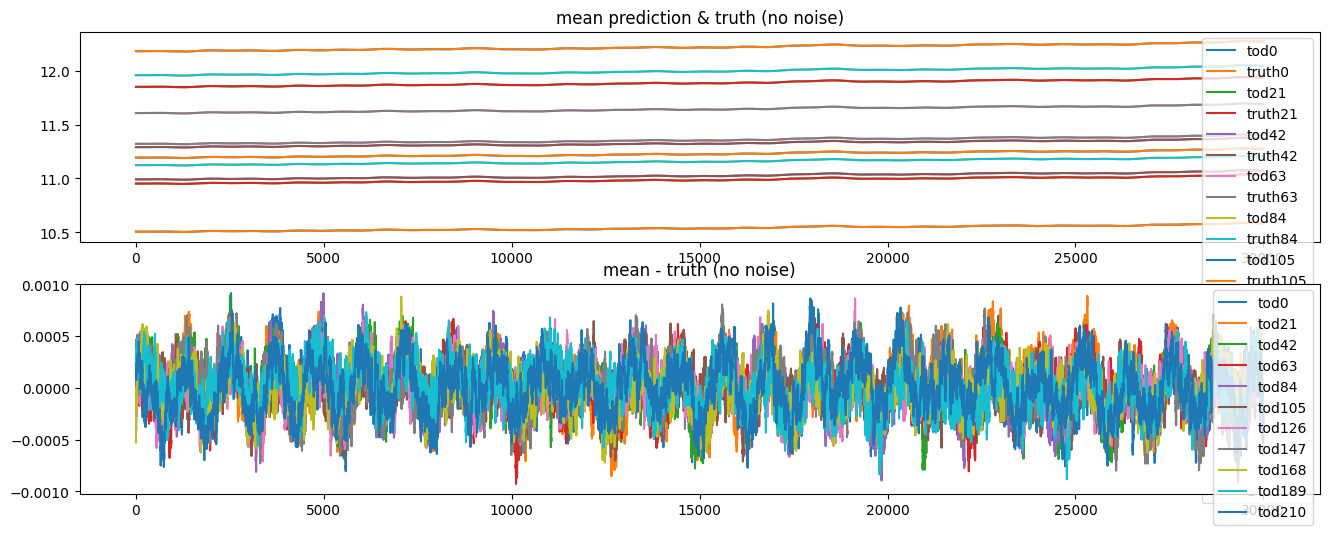

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+1.5814e+09 Δ⛰:inf ➽:8.6800e+01
SL: Iteration 1 ⛰:+1.9272e+08 Δ⛰:1.3887e+09 ➽:8.6800e+01
SL: Iteration 2 ⛰:+1.2616e+08 Δ⛰:6.6555e+07 ➽:8.6800e+01
SL: Iteration 3 ⛰:+4.0092e+07 Δ⛰:8.6072e+07 ➽:8.6800e+01
SL: Iteration 4 ⛰:+2.5849e+07 Δ⛰:1.4244e+07 ➽:8.6800e+01
SL: Iteration 5 ⛰:+2.5726e+07 Δ⛰:1.2213e+05 ➽:8.6800e+01
SL: Iteration 6 ⛰:+1.5666e+07 Δ⛰:1.0060e+07 ➽:8.6800e+01
SL: Iteration 7 ⛰:+1.2496e+07 Δ⛰:3.1709e+06 ➽:8.6800e+01
SL: Iteration 8 ⛰:+1.2461e+07 Δ⛰:3.4688e+04 ➽:8.6800e+01
SL: Iteration 9 ⛰:+9.2721e+06 Δ⛰:3.1888e+06 ➽:8.6800e+01
SL: Iteration 10 ⛰:+9.2685e+06 Δ⛰:3.6418e+03 ➽:8.6800e+01
SL: Iteration 11 ⛰:+6.7830e+06 Δ⛰:2.4854e+06 ➽:8.6800e+01
SL: Iteration 12 ⛰:+5.9194e+06 Δ⛰:8.6361e+05 ➽:8.6800e+01
SL: Iteration 13 ⛰:+4.6184e+06 Δ⛰:1.3011e+06 ➽:8.6800e+01
SL: Iteration 14 ⛰:+4.6171e+06 Δ⛰:1.2393e+03 ➽:8.6800e+01
SL: Iteration 15 ⛰:+4.6170e+06 Δ⛰:1.0447e+02 ➽:8.6800e+01
SL: Iteration 16 ⛰:+3.6363e+06 Δ⛰:9.8074e+05 ➽:8.6800e+01
SL: 

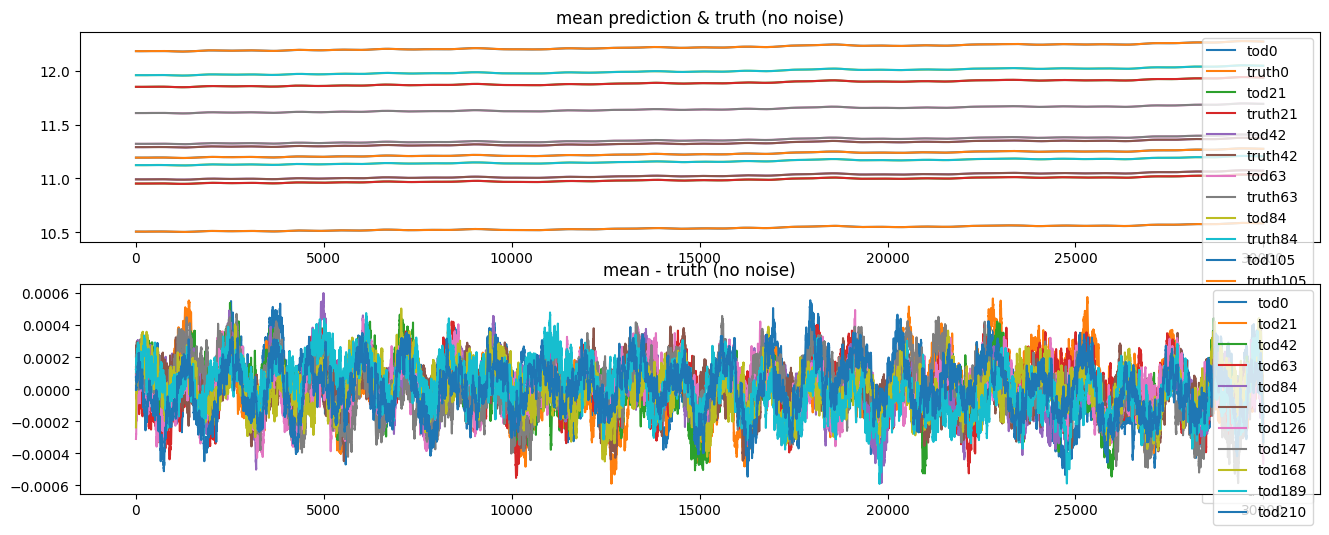

OPTIMIZE_KL: Starting 0007
SL: Iteration 0 ⛰:+2.4484e+08 Δ⛰:inf ➽:8.6800e+01
SL: Iteration 1 ⛰:+1.5190e+08 Δ⛰:9.2949e+07 ➽:8.6800e+01
SL: Iteration 2 ⛰:+1.4261e+08 Δ⛰:9.2861e+06 ➽:8.6800e+01
SL: Iteration 3 ⛰:+4.1735e+07 Δ⛰:1.0087e+08 ➽:8.6800e+01
SL: Iteration 4 ⛰:+2.6597e+07 Δ⛰:1.5138e+07 ➽:8.6800e+01
SL: Iteration 5 ⛰:+1.5706e+07 Δ⛰:1.0892e+07 ➽:8.6800e+01
SL: Iteration 6 ⛰:+1.4997e+07 Δ⛰:7.0857e+05 ➽:8.6800e+01
SL: Iteration 7 ⛰:+1.1039e+07 Δ⛰:3.9584e+06 ➽:8.6800e+01
SL: Iteration 8 ⛰:+9.5191e+06 Δ⛰:1.5195e+06 ➽:8.6800e+01
SL: Iteration 9 ⛰:+8.9374e+06 Δ⛰:5.8173e+05 ➽:8.6800e+01
SL: Iteration 10 ⛰:+5.5775e+06 Δ⛰:3.3600e+06 ➽:8.6800e+01
SL: Iteration 11 ⛰:+5.5497e+06 Δ⛰:2.7773e+04 ➽:8.6800e+01
SL: Iteration 12 ⛰:+4.3176e+06 Δ⛰:1.2321e+06 ➽:8.6800e+01
SL: Iteration 13 ⛰:+3.5007e+06 Δ⛰:8.1693e+05 ➽:8.6800e+01
SL: Iteration 14 ⛰:+2.3951e+06 Δ⛰:1.1056e+06 ➽:8.6800e+01
SL: Iteration 15 ⛰:+2.3937e+06 Δ⛰:1.4003e+03 ➽:8.6800e+01
SL: Iteration 16 ⛰:+2.3902e+06 Δ⛰:3.4474e+03 ➽:8.6800e+01
SL: 

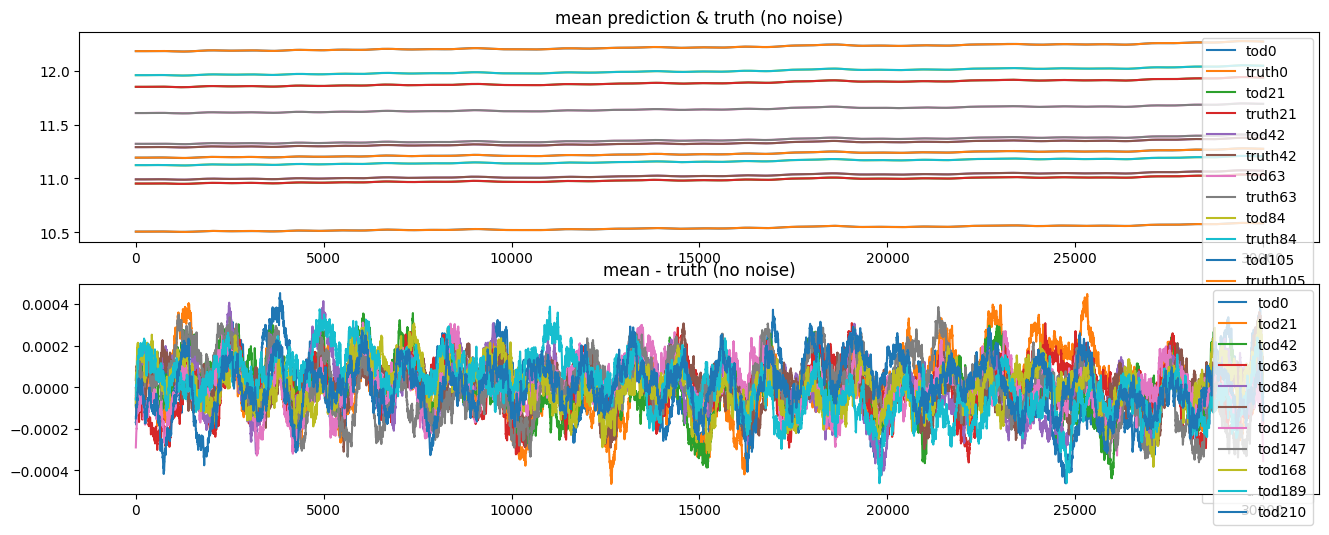

OPTIMIZE_KL: Starting 0009
SL: Iteration 0 ⛰:+1.2743e+10 Δ⛰:inf ➽:8.6800e+01
SL: Iteration 1 ⛰:+1.9315e+08 Δ⛰:1.2549e+10 ➽:8.6800e+01
SL: Iteration 2 ⛰:+1.8724e+08 Δ⛰:5.9109e+06 ➽:8.6800e+01
SL: Iteration 3 ⛰:+4.0505e+07 Δ⛰:1.4674e+08 ➽:8.6800e+01
SL: Iteration 4 ⛰:+2.5948e+07 Δ⛰:1.4557e+07 ➽:8.6800e+01
SL: Iteration 5 ⛰:+2.5311e+07 Δ⛰:6.3706e+05 ➽:8.6800e+01
SL: Iteration 6 ⛰:+1.4034e+07 Δ⛰:1.1277e+07 ➽:8.6800e+01
SL: Iteration 7 ⛰:+9.1804e+06 Δ⛰:4.8532e+06 ➽:8.6800e+01
SL: Iteration 8 ⛰:+9.1774e+06 Δ⛰:2.9880e+03 ➽:8.6800e+01
SL: Iteration 9 ⛰:+7.6711e+06 Δ⛰:1.5063e+06 ➽:8.6800e+01
SL: Iteration 10 ⛰:+6.9414e+06 Δ⛰:7.2974e+05 ➽:8.6800e+01
SL: Iteration 11 ⛰:+4.6119e+06 Δ⛰:2.3295e+06 ➽:8.6800e+01
SL: Iteration 12 ⛰:+2.8972e+06 Δ⛰:1.7147e+06 ➽:8.6800e+01
SL: Iteration 13 ⛰:+2.3240e+06 Δ⛰:5.7320e+05 ➽:8.6800e+01
SL: Iteration 14 ⛰:+2.1229e+06 Δ⛰:2.0117e+05 ➽:8.6800e+01
SL: Iteration 15 ⛰:+1.6803e+06 Δ⛰:4.4255e+05 ➽:8.6800e+01
SL: Iteration 16 ⛰:+1.3976e+06 Δ⛰:2.8275e+05 ➽:8.6800e+01
SL: 

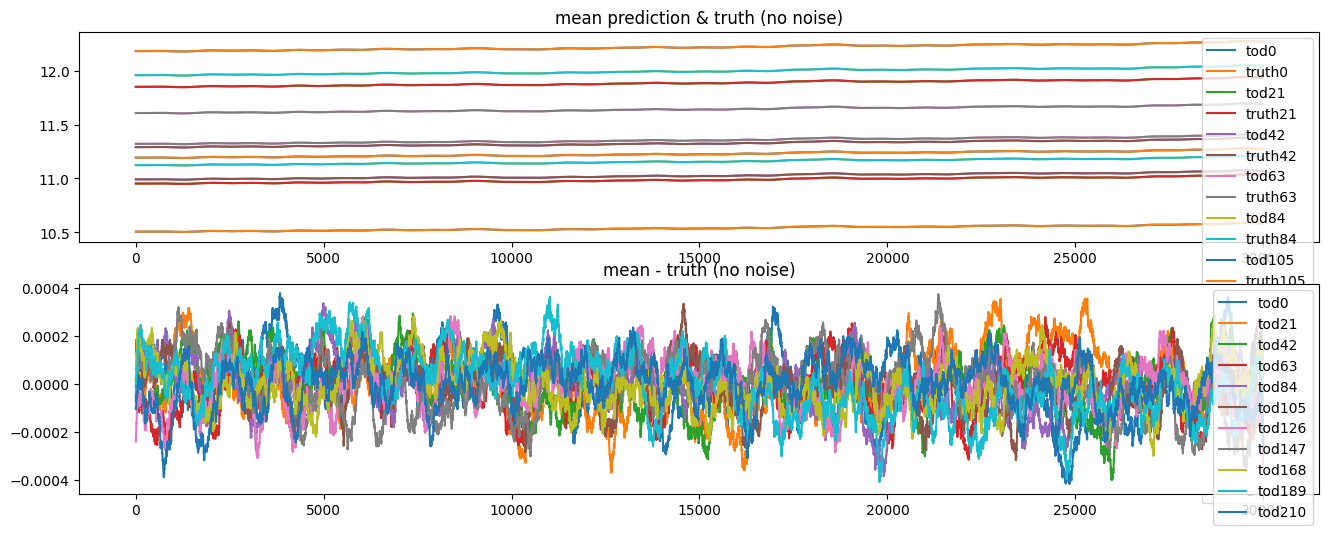

In [54]:
n_it = 10
# n_it = 30
# n_it = 50

if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    if opt_state[0] % 2 != 0: return 
    
    mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))

    for i in range(0, n, n//10 if n//10 != 0 else 1):
        axes_tods[0].plot(np.arange(0, mean.shape[1]), mean[i], label=f"tod{i}")
        axes_tods[0].plot(denoised_jax_tod[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i], label=f"tod{i}")

    axes_tods[0].title.set_text('mean prediction & truth (no noise)')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('mean - truth (no noise)')
    axes_tods[1].legend()

    plt.show()
    

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

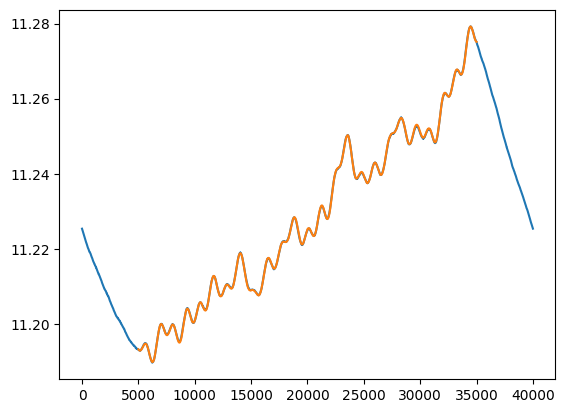

In [55]:
# offset_results = jft.NormalPrior(**offset_dict)(samples.pos['offset'])
# offset_results = offset_tod
pred = gp_tod({k: samples.pos[k] for k in samples.pos if 'comb' in k}) * slopes_truth[:, None] + offset_tod_truth[:, None]
padded_truth = np.pad(denoised_jax_tod[0], pad_width=padding_atmos//2, mode='constant', constant_values=np.nan)

plt.plot(pred[0])
plt.plot(padded_truth)

In [56]:
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.001590399887194622, 0.002, 0.001
	loglogvarslope: -2.3710062677823487, -2.5, 0.5
	zeromode std (LogNormal): 1.0991168887933128e-07, 1e-05, 9.9e-06


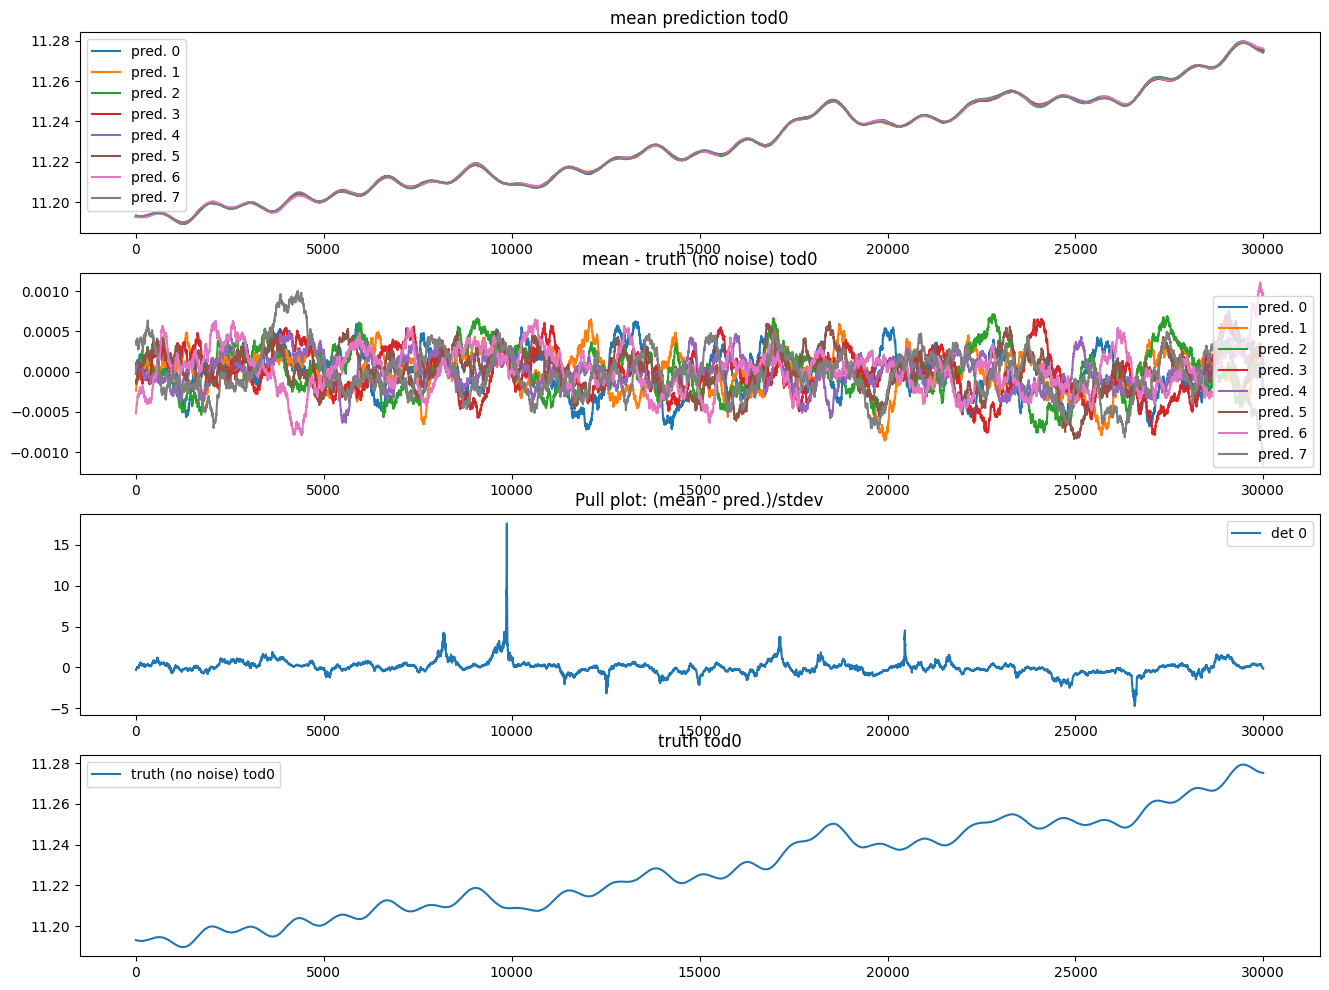

In [57]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 0 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()

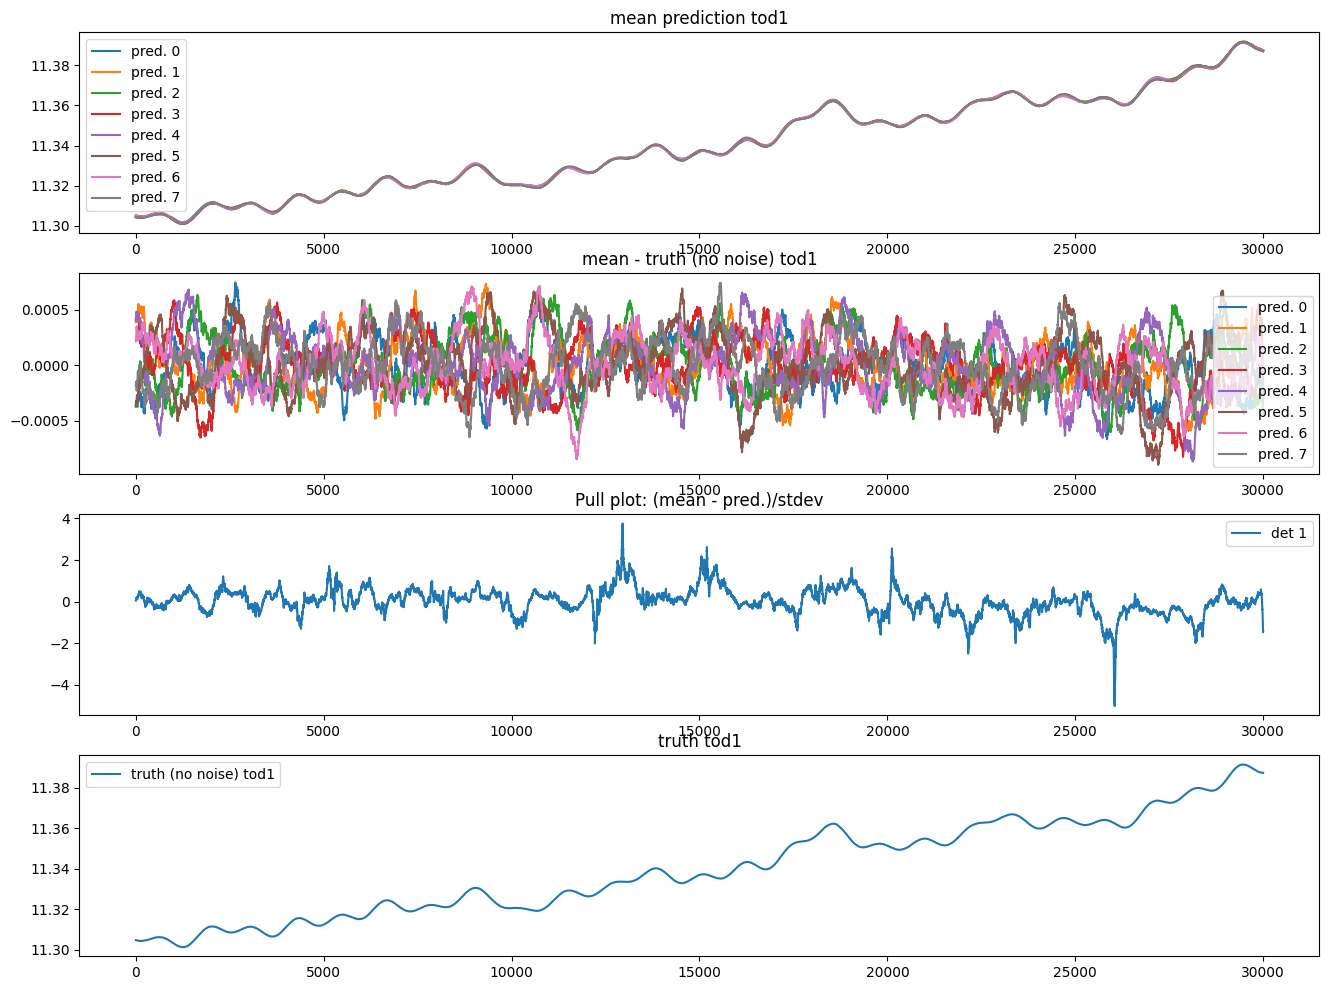

In [58]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 1 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()